In [1]:
! [ -e /content ] && pip install -Uqq fastai 

In [2]:
from fastai.vision.all import *
from fastai.text.all import *
from fastai.collab import *
from fastai.tabular.all import * 
# do not use from fastai2....all import *
# don't work

In [3]:
path = untar_data(URLs.PETS)

In [4]:
path.ls()

(#2) [Path('/home/sergey/.fastai/data/oxford-iiit-pet/images'),Path('/home/sergey/.fastai/data/oxford-iiit-pet/annotations')]

In [5]:
(path/'images').ls()

(#7393) [Path('/home/sergey/.fastai/data/oxford-iiit-pet/images/american_pit_bull_terrier_72.jpg'),Path('/home/sergey/.fastai/data/oxford-iiit-pet/images/Russian_Blue_145.jpg'),Path('/home/sergey/.fastai/data/oxford-iiit-pet/images/Russian_Blue_119.jpg'),Path('/home/sergey/.fastai/data/oxford-iiit-pet/images/pug_98.jpg'),Path('/home/sergey/.fastai/data/oxford-iiit-pet/images/Abyssinian_226.jpg'),Path('/home/sergey/.fastai/data/oxford-iiit-pet/images/pug_178.jpg'),Path('/home/sergey/.fastai/data/oxford-iiit-pet/images/samoyed_5.jpg'),Path('/home/sergey/.fastai/data/oxford-iiit-pet/images/Abyssinian_37.jpg'),Path('/home/sergey/.fastai/data/oxford-iiit-pet/images/pug_25.jpg'),Path('/home/sergey/.fastai/data/oxford-iiit-pet/images/beagle_63.jpg')...]

In [6]:
fname = (path/'images').ls()[0]

In [7]:
import re
re.findall(r'(.+)_\d+.jpg$', fname.name)

['american_pit_bull_terrier']

In [8]:
"""
Этап разметки изображений датасета в том числе и с помощью регулярных выражений
"""

pets = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 
                 get_items=get_image_files,
                 
                 splitter=RandomSplitter(seed=42),
                 
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 
                 # обрезка полной ширины или высоты
                 item_tfms=Resize(460),
                 # случайна обрезка и аугментация
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))

dls = pets.dataloaders(path/'images')

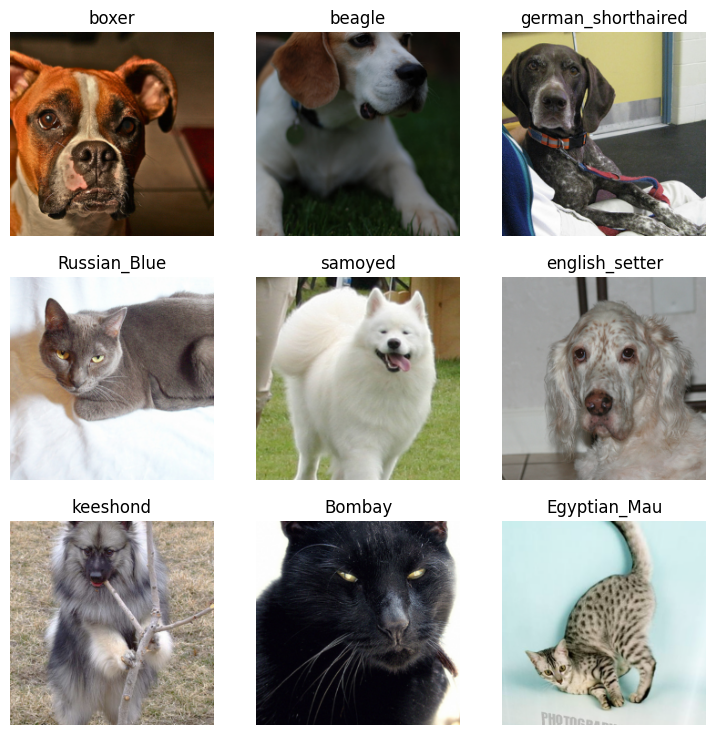

In [9]:
"""
Для того, чтобы избежать определенных ошибок при аугментации и предшествоющих операций искажения
исходного изображения надо изначально провести 
все необходимые преобразования (обрезка полной ширины или высоты), 
    1) Увеличение изобрадения до относительно "больших" размеров, чтобы 
    они казались существенно борльше целевых размеров для обучения.
    2) Объединение всех стандартных операций аугментаци (включая операции по изменению размера 
    на итоговой целевой) в одну и выполение совмещенной операции на GPU всего один раз в конце обработки.
    Это устраняет необходимость веполнения всех операций по отдельности и многократного интерполирования.
"""

# проверка работы datablock
dls.show_batch(nrows=3, ncols=3)

In [11]:
pets1 = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 
                 get_items=get_image_files,
                 
                 splitter=RandomSplitter(seed=42),
                 
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'))

# Неверный подход
try:
    pets1.summary(path/'images')
except RuntimeError:
    pets.summary(path/'images')

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /home/sergey/.fastai/data/oxford-iiit-pet/images/Siamese_257.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=300x289
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /home/sergey/.fastai/data/oxford-iiit-pet/images/Siamese_257.jpg
    applying partial gives
      Siamese
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(10)

Final sample: (PILImage mode=RGB size=300x289, TensorCategory(10))


Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up aft

In [ ]:
learn = vision_learner(
    # dls содержит верный набор pets
    dls, 
    # модель 34 слоя
    resnet8,
    # метрика
    metrics=error_rate)

learn.fine_tune(2)